## Deep Learning: Exam 2

### Author: Alexandre de Carvalho Assunção

In this exam/project, I'll build and train a pix2pix GAN to translate satelite images to google map images. GAN's are rather unique generative models: they are two models, a generator and a discriminator, playing a zero-sum game against each other. To explain the GAN I need to explain each of these components and how they are connected. I'll do so as I progress through this notebook, trying to make clear the purpose of each code cell.

This notebook will be divided in roughly three sections:

- Preprocessing dataset
- Building the generator and discriminator
- Building the GAN
- Training the GAN

Any questions, feel free to contact the author at: alexcarssuncao@gmail.com

## 1- Preprocessing dataset:

>> #### 1.1 - Preliminary imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

>> #### 1.2- Downloading and Loading the Dataset

I chose the maps dataset used in the original pix2pix paper to train my GAN. It was relatively small, easy to access, and still intresting. Below follows the functions to download the dataset and to load it. The only noteworthy thing about these two functions is that each image contains both the satelite image and the maps image forcing us to split them.  

In [ ]:
# Downloading the dataset from the pix2pix website:

!apt-get install wget
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz -O maps.tar.gz

# Extracting the tar.gz file
import tarfile

# Opening and extracting the tar.gz file
with tarfile.open('maps.tar.gz', 'r:gz') as tar:
    tar.extractall(path='maps_dataset')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
--2024-08-07 01:02:40--  https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  61.6MB/s    in 4.4s    

2024-08-07 01:02:45 (54.3 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
def load_dataset(dataset_path, target_size=(256, 512)):

    map_images = []
    sat_images = []

    for image_file in os.listdir(dataset_path):

        image = load_img(dataset_path + image_file, target_size=target_size)
        image_array = img_to_array(image)

        sat_part = image_array[:, :256]
        map_part = image_array[:, 256:]

        map_images.append(map_part)
        sat_images.append(sat_part)

    return map_images, sat_images

In [ ]:
maps_dataset_dir = 'maps_dataset'
path_to_training_data = os.path.join(maps_dataset_dir, 'maps/train/')

map_imgs, sat_imgs = load_dataset(path_to_training_data)

print(f"Loaded {len(sat_imgs)} satellite images and {len(map_imgs)} map images.")
print(f"Sat Images shape: {sat_imgs[0].shape}")
print(f"Map Images shape: {map_imgs[0].shape}")

Loaded 1096 satellite images and 1096 map images.
Sat Images shape: (256, 256, 3)
Map Images shape: (256, 256, 3)


>> #### 1.3- Visualizing the images:

The following cell uses matplotlib to print a few of the images from the dataset so we can see if the loading process proceeded smoothly.

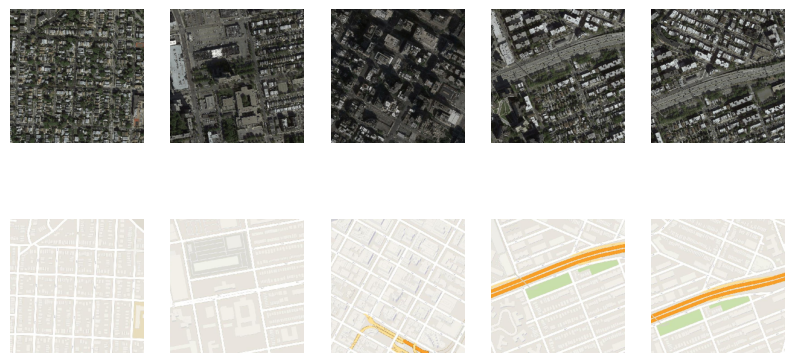

In [ ]:
def visualize_images(sat_imgs, map_imgs, n=5):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(sat_imgs[i].astype(np.uint8))
        plt.axis('off')
        plt.subplot(2, n, n+i+1)
        plt.imshow(map_imgs[i].astype(np.uint8))
        plt.axis('off')
    plt.show()

# Print a few images to check
if len(sat_imgs) > 0 and len(map_imgs) > 0:
    visualize_images(sat_imgs, map_imgs, n=5)
else:
    print("No images to display.")

>> #### 1.4- Normalizing the images:

Since the values of the images' pixels vary from 0 to 255, we "squish" them to [-1, 1] for the tanh function that we'll use later.

In [ ]:
# Normalizing the images for better performance:

def normalize_image(image):
    return (image / 127.5) - 1

def denormalize_image(image):
    return (image + 1) * 127.5

for i in range(len(sat_imgs)):
  sat_imgs[i] = normalize_image(sat_imgs[i])
  map_imgs[i] = normalize_image(map_imgs[i])

## 2- The Generator:

The generator in a Pix2Pix GAN functions similarly to an autoencoder: we downsample an input image to a small-dimensional bottleneck and then upsample it back to an image with the same dimensions as the input. However, as I'll discuss during the training process, the generator's loss sets it apart from a traditional autoencoder.

I've implemented two versions of the generator:

1. **The original version from the Pix2Pix paper.**
2. **A simplified version that uses less memory.**

Both versions share the same overall structure:

- **Encoder blocks**: Convolutional layers with Leaky ReLU activations, optionally followed by batch normalization. The filter size, stride, and padding are consistent across all encoder blocks.
  
- **Bottleneck**: A convolutional layer with Leaky ReLU activation that compresses the image to a small-dimensional space with many channels, ideally capturing semantically rich features of the input image.
  
- **Decoder blocks**: Layers of transpose convolutions with Leaky ReLU activations, which may include dropout. To improve gradient flow, we use residual connections (adding inputs from the previous layer to the current layer’s output).
  
- **Final layer**: A convolutional layer with a tanh activation instead of Leaky ReLU, which helps constrain the output values within the interval `[-1, 1]`.

The only difference between the original and simplified generators is the number of encoder/decoder blocks used.

>> #### Original Pix2pix Generator

In [ ]:
def build_original_generator(input_shape=(256, 256, 3)):
     """
     Builds a U-Net-like generator model for a Pix2Pix GAN.

     The generator takes an input image and produces a transformed output image.
     It uses an encoder-decoder architecture with skip connections to preserve high-resolution details.

     Args:
         input_shape (tuple): Shape of the input images, including the number of channels.
                             Default is (256, 256, 3).

     Returns:
         Model: A Keras Model representing the generator.
    """

     # ENCODER BLOCK:
     #   Downsamples the imput image using convolutional layers
     def encoder_block(input_layer, filters, batch_norm=True):
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(input_layer)
        if batch_norm:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

     # DECODER BLOCK:
     #   Upsamples the bottleneck with skip connections
     def decoder_block(input_layer, skip_layer, filters, dropout=True):
        x = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same')(input_layer)
        x = BatchNormalization()(x)
        if dropout:
            x = Dropout(0.5)(x)
        x = Concatenate()([x, skip_layer])
        x = LeakyReLU(alpha=0.2)(x)
        return x

     inputs = Input(shape=input_shape)

     # Encoder
     e1 = encoder_block(inputs, 64, batch_norm=False)
     e2 = encoder_block(e1, 128)
     e3 = encoder_block(e2, 256)
     e4 = encoder_block(e3, 512)
     e5 = encoder_block(e4, 512)
     e6 = encoder_block(e5, 512)
     e7 = encoder_block(e6, 512)

     # Bottleneck
     bottleneck = Conv2D(512, kernel_size=4, strides=2, padding='same')(e7)
     bottleneck = LeakyReLU(alpha=0.2)(bottleneck)

     # Decoder
     d1 = decoder_block(bottleneck, e7, 512)
     d2 = decoder_block(d1, e6, 512)
     d3 = decoder_block(d2, e5, 512)
     d4 = decoder_block(d3, e4, 512, dropout=False)
     d5 = decoder_block(d4, e3, 256, dropout=False)
     d6 = decoder_block(d5, e2, 128, dropout=False)
     d7 = decoder_block(d6, e1, 64, dropout=False)

     outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(d7)

     return Model(inputs, outputs)

>> #### Simplified Pix2pix generator for memory efficiency

In [ ]:
def build_generator(input_shape=(256, 256, 3)):

    # ENCODER BLOCK:
    def encoder_block(input_layer, filters, batch_norm=True):
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(input_layer)
        if batch_norm:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    # DECODER BLOCK:
    def decoder_block(input_layer, skip_layer, filters, dropout=True):
        x = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same')(input_layer)
        x = BatchNormalization()(x)
        if dropout:
            x = Dropout(0.5)(x)
        x = Concatenate()([x, skip_layer])
        x = LeakyReLU(alpha=0.2)(x)
        return x

    inputs = Input(shape=input_shape)

    # Encoder
    e1 = encoder_block(inputs, 64, batch_norm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)

    # Bottleneck
    bottleneck = Conv2D(512, kernel_size=4, strides=2, padding='same')(e3)
    bottleneck = LeakyReLU(alpha=0.2)(bottleneck)

    # Decoder
    d1 = decoder_block(bottleneck, e3, 256)
    d2 = decoder_block(d1, e2, 128)
    d3 = decoder_block(d2, e1, 64, dropout=False)

    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(d3)

    return Model(inputs, outputs)

# Create the model
generator = build_generator()


>> #### 2.1- Testing the generator

The following code cell takes an untrained generator and has it generate an image. It also prints relevant information about the model, such as the size of each layer's inputs and outputs and the number of parameters that need to be trained.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │          3,136 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 32, 256)    │          1,024 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,664 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 256)    │      2,097,408 │ leaky_re_lu_10[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32, 32, 256)    │          1,024 │ conv2d_transpose_4[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 32, 32, 512)    │              0 │ dropout_2[0][0],       │
│ (Concatenate)             │                        │                │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 32, 32, 512)    │              0 │ concatenate_3[0][0]    │
│ (LeakyReLU)          

 Total params: 6,174,339 (23.55 MB)

 Trainable params: 6,172,675 (23.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Generated image shape: (1, 256, 256, 3)


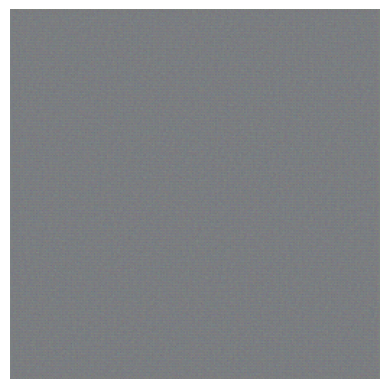

In [ ]:
# Create the generator model
generator = build_generator()

# Print the model summary to inspect shapes
generator.summary()

# Create a dummy input to test the model
dummy_input = np.random.rand(1, 256, 256, 3).astype(np.float32)

# Get the output of the generator for the dummy input
generated_image = generator.predict(dummy_input)

# Print the shape of the output
print(f'Generated image shape: {generated_image.shape}')

# Visualize the generated image
def visualize_image(image):
    # Remove batch dimension
    image = image.squeeze()
    # Rescale the image from [-1, 1] to [0, 1] due to tanh activation
    image = (image + 1) / 2.0
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize the generated image
visualize_image(generated_image)

## 3- The Discriminator:

By itself, a GAN's discriminator is rather straightforward. It's a non-linear classifier composed of convolutional layers. The discriminator receives two input images: one is the generated image (which it doesn't know whether is real or fake), and the other is the target image (which it does know whether is real or fake). These images are concatenated into a single tensor.

The concatenated tensor is then passed through a series of convolutional layers. Each convolutional layer processes progressively larger patches of the concatenated images, classifying these patches as real or fake. This patch-based approach helps the discriminator focus on local details and texture patterns.

At the final layer, the discriminator outputs a single value (a raw logit) for each patch, which represents the confidence that the patches belong to real images. These logits are not yet probabilities but will be converted into probabilities during training using a sigmoid function. The ultimate goal of the discriminator is to distinguish between real image pairs and generated image pairs, providing feedback to the generator to improve its outputs.

In [ ]:
def build_discriminator(input_shape=(256, 256, 3)):
    """
    Builds a PatchGAN discriminator model for a Pix2Pix GAN.

    The discriminator takes two inputs: an image and a target (ground truth) image,
    and classifies each NxN patch in the concatenated input as real or fake.

    Args:
        input_shape (tuple): Shape of the input images, including the number of channels.
                             Default is (256, 256, 3).

    Returns:
        Model: A Keras Model representing the PatchGAN discriminator.
    """

    def discriminator_block(input_layer, filters, strides=2, batch_norm=True):
        """
        Creates a convolutional block for the discriminator model.

        Args:
            input_layer (tensor): Input tensor to the convolutional block.
            filters (int): Number of filters for the Conv2D layer.
            strides (int): Stride size for the Conv2D layer. Default is 2.
            batch_norm (bool): Whether to include BatchNormalization. Default is True.

        Returns:
            tensor: Output tensor of the convolutional block.
        """
        x = Conv2D(filters, kernel_size=4, strides=strides, padding='same')(input_layer)
        if batch_norm:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    inputs_image = Input(shape=input_shape)
    inputs_target = Input(shape=input_shape)

    # Concatenate the input image and the target image along the channels axis
    x = Concatenate()([inputs_image, inputs_target])

    # Apply a series of discriminator blocks
    d1 = discriminator_block(x, 64, batch_norm=False)  # First block without batch normalization
    d2 = discriminator_block(d1, 128)
    d3 = discriminator_block(d2, 256)
    d4 = discriminator_block(d3, 512, strides=1)  # Last block with a stride of 1

    # Final Conv2D layer to produce a single-channel output
    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([inputs_image, inputs_target], outputs)


In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 256, 256, 6)    │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │          6,208 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 128, 128, 64)   │              0 │ conv2d_8[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ leaky_re_lu_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 64, 128)    │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 256)    │        524,544 │ leaky_re_lu_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 256)    │          1,024 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 32, 32, 256)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 512)    │      2,097,664 │ leaky_re_lu_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 32, 32, 512)    │          2,048 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_17            │ (None, 32, 32, 512)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)   

 Total params: 2,771,393 (10.57 MB)

 Trainable params: 2,769,601 (10.57 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 4- The GAN

Now it's time to build the GAN. We define a function that returns a Keras model, which takes an input satellite image. This image is fed into the generator, which produces our target map image. The output from the generator is then passed through the discriminator, which evaluates how confident it is in determining whether the generated image is real or fake. The discriminator's feedback helps guide the training of the generator.

In [ ]:
def build_gan(generator, discriminator):

    # During the GAN training we want to keep the discriminator/
    # static to evaluate the generator's performance
    discriminator.trainable = False

    # Make sure the input image has sizse 256x256 and 3 channels
    input_image = Input(shape=(256, 256, 3))

    # Generate image based on the source input image
    generated_image = generator(input_image)

    # See if we can fool the discriminator. The validity score we get will guide the generator's training
    validity = discriminator([input_image, generated_image])

    return Model(input_image, [validity, generated_image])

### Simple debugging cell to check the gan

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 256, 256, 3)    │      6,174,339 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_3 (Functional) │ (None, 32, 32, 1)      │      2,771,393 │ input_layer_5[0][0],   │
│                           │                        │                │ functional_2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,945,732 (34.13 MB)

 Trainable params: 6,172,675 (23.55 MB)

 Non-trainable params: 2,773,057 (10.58 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


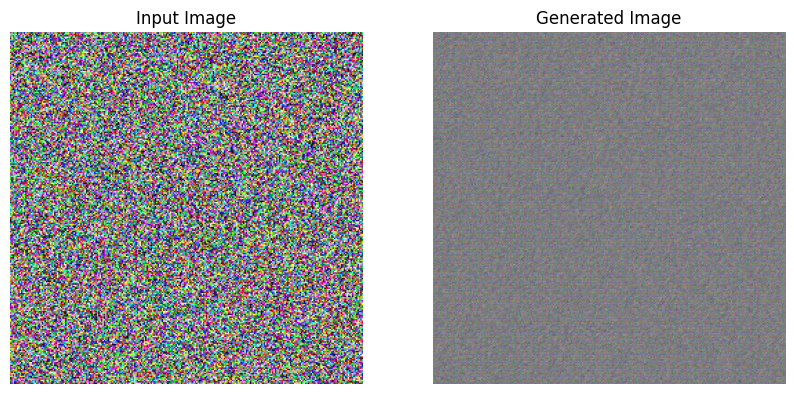

In [ ]:
# Build models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
gan.summary()

# Create dummy input for testing
dummy_input = np.random.randn(1, 256, 256, 3)

# Generate image
generated_image = generator.predict(dummy_input)

# Get discriminator output
discriminator_output = discriminator.predict([dummy_input, generated_image])

# Visualize images
def visualize_images(input_img, generated_img):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow((input_img[0] + 1) / 2)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    generated_img = generated_img.squeeze()
    plt.title('Generated Image')
    plt.imshow((generated_img + 127) / 2)
    plt.axis('off')

    plt.show()

visualize_images(dummy_input, generated_image)

### Training the GAN

The training process for the GAN involves both the generator and the discriminator, optimized through adversarial loss. The train function iterates over the dataset for a specified number of epochs. In each step, real and target images are used to create the labels for training the discriminator: real images are labeled as 1, and fake images as 0. The discriminator is first trained on real images, then on fake images generated by the generator, and the losses from both are combined to calculate the total discriminator loss. The generator is then trained using the combined GAN model, where the goal is to improve its ability to produce images that can fool the discriminator. The function prints the discriminator and generator losses at the end of each epoch, providing feedback on the training progress.

In [ ]:
def train(generator, discriminator, gan, dataset, epochs=1, batch_size=1):

    # Adversarial loss
    adversarial_loss = BinaryCrossentropy(from_logits=True)

    # Optimizer
    optimizer = Adam(0.0002, 0.5)

    for epoch in range(epochs):

        for step, (real_images, target_images) in enumerate(dataset):

            batch_size = real_images.shape[0]

            # Creating the labels to train the discriminator
            real = np.ones((batch_size, 32, 32, 1))
            fake = np.zeros((batch_size, 32, 32, 1))

            # ---------------------Train Discriminator---------------------#

            # a) Use generator to create false images:
            generated_images = generator.predict(real_images, verbose=0)

            # b) Update discriminator using real images.
            d_loss_real = discriminator.train_on_batch([real_images, target_images], real)

            # c) Update discriminator using the fake images made by the generator.
            d_loss_fake = discriminator.train_on_batch([real_images, generated_images], fake)

            # d) Combine the losses from real and fake images to get the total discriminator loss.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------Train Generator--------------------------#

            # Use combined GAN model to update the generator
            g_loss = gan.train_on_batch(real_images, [real, target_images])

        print(f'Epoch: {epoch+1}, D Loss: {d_loss}, G Loss: {g_loss}')

        if (epoch + 1) % 20 == 0:
            generator.save(f'generator_epoch_{epoch+1}.h5')
            discriminator.save(f'discriminator_epoch_{epoch+1}.h5')


## Putting it all together

In [ ]:
# Load dataset
input_images = sat_imgs[:900]
target_images = map_imgs[:900]

# Build and compile models
generator = build_original_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

discriminator.compile(optimizer=Adam(0.0002, 0.5), loss=BinaryCrossentropy(from_logits=True))
gan.compile(optimizer=Adam(0.0002, 0.5), loss=[BinaryCrossentropy(from_logits=True), 'mae'])

discriminator.trainable = True

# Combine datasets
dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images)).batch(32)

# Train the models
train(generator, discriminator, gan, dataset, epochs=200, batch_size=32)


Epoch: 1, D Loss: 0.6982520222663879, G Loss: [0.9264646768569946, 0.6522257924079895, 0.2742389142513275]
Epoch: 2, D Loss: 0.6988853216171265, G Loss: [0.8041685819625854, 0.6824796199798584, 0.12168893963098526]
Epoch: 3, D Loss: 0.700532853603363, G Loss: [0.8001072406768799, 0.6835835576057434, 0.11652370542287827]
Epoch: 4, D Loss: 0.7036569118499756, G Loss: [0.7999082803726196, 0.683661699295044, 0.11624657362699509]
Epoch: 5, D Loss: 0.699098527431488, G Loss: [0.7983927130699158, 0.6841299533843994, 0.11426278203725815]
Epoch: 6, D Loss: 0.6991382241249084, G Loss: [0.7960502505302429, 0.6841955184936523, 0.11185473203659058]
Epoch: 7, D Loss: 0.6985274851322174, G Loss: [0.7930628657341003, 0.6845205426216125, 0.108542300760746]
Epoch: 8, D Loss: 0.6978654563426971, G Loss: [0.7904579043388367, 0.6849887371063232, 0.10546918213367462]
Epoch: 9, D Loss: 0.6979359686374664, G Loss: [0.7883859872817993, 0.6853291988372803, 0.10305681824684143]
Epoch: 10, D Loss: 0.6973876953125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 20, D Loss: 0.6967707872390747, G Loss: [0.7782269716262817, 0.6875444650650024, 0.0906825140118599]
Epoch: 21, D Loss: 0.6969002485275269, G Loss: [0.7789502739906311, 0.6875419616699219, 0.09140832722187042]
Epoch: 22, D Loss: 0.6976438164710999, G Loss: [0.7776263952255249, 0.6878135204315186, 0.08981289714574814]
Epoch: 23, D Loss: 0.6978299617767334, G Loss: [0.7759057283401489, 0.6878525018692017, 0.08805321156978607]
Epoch: 24, D Loss: 0.6973985135555267, G Loss: [0.7750945091247559, 0.6881428956985474, 0.0869516134262085]
Epoch: 25, D Loss: 0.6976522207260132, G Loss: [0.7738697528839111, 0.6879689693450928, 0.08590079098939896]
Epoch: 26, D Loss: 0.697769820690155, G Loss: [0.772667646408081, 0.6880298256874084, 0.0846378356218338]
Epoch: 27, D Loss: 0.6977476477622986, G Loss: [0.7724230885505676, 0.6881192922592163, 0.08430378139019012]
Epoch: 28, D Loss: 0.6978759467601776, G Loss: [0.7710113525390625, 0.6882450580596924, 0.08276627212762833]
Epoch: 29, D Loss: 0.697

Epoch: 40, D Loss: 0.6976716220378876, G Loss: [0.7611522078514099, 0.6883077025413513, 0.07284452766180038]
Epoch: 41, D Loss: 0.6977224051952362, G Loss: [0.7603667378425598, 0.6887220144271851, 0.07164472341537476]
Epoch: 42, D Loss: 0.6976039409637451, G Loss: [0.7599327564239502, 0.6887122988700867, 0.07122045010328293]
Epoch: 43, D Loss: 0.6974185705184937, G Loss: [0.7592912316322327, 0.6889090538024902, 0.07038216292858124]
Epoch: 44, D Loss: 0.6975514888763428, G Loss: [0.7595070004463196, 0.6890575885772705, 0.07044943422079086]
Epoch: 45, D Loss: 0.6973104774951935, G Loss: [0.7583563923835754, 0.6889309883117676, 0.06942540407180786]
Epoch: 46, D Loss: 0.6975040435791016, G Loss: [0.7580438256263733, 0.6888555288314819, 0.06918828189373016]
Epoch: 47, D Loss: 0.6972370445728302, G Loss: [0.7568041086196899, 0.6892929673194885, 0.0675111636519432]
Epoch: 48, D Loss: 0.6970575451850891, G Loss: [0.7555626034736633, 0.689421534538269, 0.0661410540342331]
Epoch: 49, D Loss: 0.6

Epoch: 60, D Loss: 0.6970503330230713, G Loss: [0.7491713166236877, 0.6901684999465942, 0.059002794325351715]
Epoch: 61, D Loss: 0.6969046592712402, G Loss: [0.7486501932144165, 0.69026780128479, 0.05838236212730408]
Epoch: 62, D Loss: 0.6970343589782715, G Loss: [0.7485506534576416, 0.6902786493301392, 0.05827201530337334]
Epoch: 63, D Loss: 0.6968702673912048, G Loss: [0.7484864592552185, 0.6902412176132202, 0.0582452267408371]
Epoch: 64, D Loss: 0.6968200504779816, G Loss: [0.7470435500144958, 0.6903330087661743, 0.05671054124832153]
Epoch: 65, D Loss: 0.6968133449554443, G Loss: [0.7466269731521606, 0.6905380487442017, 0.05608893930912018]
Epoch: 66, D Loss: 0.6967179775238037, G Loss: [0.7457564473152161, 0.6907087564468384, 0.05504769831895828]
Epoch: 67, D Loss: 0.6966120004653931, G Loss: [0.7451545000076294, 0.6907424926757812, 0.05441203713417053]
Epoch: 68, D Loss: 0.6967326998710632, G Loss: [0.7453675866127014, 0.6905488967895508, 0.05481867492198944]
Epoch: 69, D Loss: 0.

Epoch: 80, D Loss: 0.6963910758495331, G Loss: [0.7410678863525391, 0.6913292407989502, 0.04973861575126648]
Epoch: 81, D Loss: 0.6962442994117737, G Loss: [0.7412741780281067, 0.6914108991622925, 0.04986327141523361]
Epoch: 82, D Loss: 0.6961875557899475, G Loss: [0.7401325702667236, 0.6915994882583618, 0.04853307455778122]
Epoch: 83, D Loss: 0.696340799331665, G Loss: [0.7400159239768982, 0.6914331316947937, 0.04858279228210449]
Epoch: 84, D Loss: 0.6962921917438507, G Loss: [0.7409234046936035, 0.6916716694831848, 0.04925176501274109]
Epoch: 85, D Loss: 0.6961347162723541, G Loss: [0.7409910559654236, 0.6914055943489075, 0.049585435539484024]
Epoch: 86, D Loss: 0.6962525546550751, G Loss: [0.7389146089553833, 0.6915338039398193, 0.047380782663822174]
Epoch: 87, D Loss: 0.6963049173355103, G Loss: [0.7394400835037231, 0.6917293667793274, 0.04771074652671814]
Epoch: 88, D Loss: 0.6959506869316101, G Loss: [0.7385149598121643, 0.6917387247085571, 0.046776220202445984]
Epoch: 89, D Loss

Epoch: 100, D Loss: 0.6959072351455688, G Loss: [0.7356060743331909, 0.6921167373657227, 0.043489351868629456]
Epoch: 101, D Loss: 0.6959657073020935, G Loss: [0.7360734939575195, 0.6920281648635864, 0.04404531419277191]
Epoch: 102, D Loss: 0.695875495672226, G Loss: [0.7353678345680237, 0.6922072172164917, 0.043160632252693176]
Epoch: 103, D Loss: 0.6958287060260773, G Loss: [0.7352088093757629, 0.6924062967300415, 0.04280250892043114]
Epoch: 104, D Loss: 0.6958562731742859, G Loss: [0.7353108525276184, 0.6923766136169434, 0.04293424263596535]
Epoch: 105, D Loss: 0.6958509087562561, G Loss: [0.7352034449577332, 0.6923534870147705, 0.04284995049238205]
Epoch: 106, D Loss: 0.6958572566509247, G Loss: [0.7348923683166504, 0.692384660243988, 0.042507704347372055]
Epoch: 107, D Loss: 0.6958350837230682, G Loss: [0.7344648241996765, 0.6924318075180054, 0.04203299060463905]
Epoch: 108, D Loss: 0.695746511220932, G Loss: [0.7345297932624817, 0.6925133466720581, 0.04201645404100418]
Epoch: 109

Epoch: 120, D Loss: 0.6957390308380127, G Loss: [0.7332958579063416, 0.692803144454956, 0.0404927097260952]
Epoch: 121, D Loss: 0.6955966353416443, G Loss: [0.7329609394073486, 0.6927525997161865, 0.04020830988883972]
Epoch: 122, D Loss: 0.6956743896007538, G Loss: [0.7336670756340027, 0.6926735639572144, 0.04099350422620773]
Epoch: 123, D Loss: 0.6956544816493988, G Loss: [0.7326549887657166, 0.6928572654724121, 0.03979770466685295]
Epoch: 124, D Loss: 0.6956632733345032, G Loss: [0.7331187725067139, 0.69269859790802, 0.04042014479637146]
Epoch: 125, D Loss: 0.6956155002117157, G Loss: [0.7327771782875061, 0.6926676034927368, 0.04010959342122078]
Epoch: 126, D Loss: 0.6956299543380737, G Loss: [0.7322529554367065, 0.6929166316986084, 0.03933635354042053]
Epoch: 127, D Loss: 0.6955593228340149, G Loss: [0.7318485975265503, 0.693001389503479, 0.03884720057249069]
Epoch: 128, D Loss: 0.6955590844154358, G Loss: [0.7316539883613586, 0.692997395992279, 0.03865659981966019]
Epoch: 129, D Lo

Epoch: 140, D Loss: 0.6953867673873901, G Loss: [0.7307864427566528, 0.6931746602058411, 0.037611767649650574]
Epoch: 141, D Loss: 0.6954536437988281, G Loss: [0.7305633425712585, 0.6932458281517029, 0.03731750696897507]
Epoch: 142, D Loss: 0.6954488158226013, G Loss: [0.7314698100090027, 0.6931153535842896, 0.03835447505116463]
Epoch: 143, D Loss: 0.6955122649669647, G Loss: [0.7310298681259155, 0.6932399868965149, 0.037789903581142426]
Epoch: 144, D Loss: 0.6954348683357239, G Loss: [0.7302828431129456, 0.6931288242340088, 0.03715399652719498]
Epoch: 145, D Loss: 0.6954172253608704, G Loss: [0.729712963104248, 0.6932940483093262, 0.03641892224550247]
Epoch: 146, D Loss: 0.6955010294914246, G Loss: [0.7298231720924377, 0.6932602524757385, 0.03656292334198952]
Epoch: 147, D Loss: 0.6954188942909241, G Loss: [0.7298306226730347, 0.6933885216712952, 0.03644212335348129]
Epoch: 148, D Loss: 0.6954076886177063, G Loss: [0.729831337928772, 0.6933300495147705, 0.036501288414001465]
Epoch: 14

Epoch: 160, D Loss: 0.695302814245224, G Loss: [0.7292789220809937, 0.6933388710021973, 0.03594004735350609]
Epoch: 161, D Loss: 0.6953158676624298, G Loss: [0.7288206219673157, 0.693483829498291, 0.03533677011728287]
Epoch: 162, D Loss: 0.6952291131019592, G Loss: [0.7288851737976074, 0.6936378479003906, 0.035247355699539185]
Epoch: 163, D Loss: 0.6952838599681854, G Loss: [0.7287419438362122, 0.6935508251190186, 0.03519109636545181]
Epoch: 164, D Loss: 0.695305347442627, G Loss: [0.7284883260726929, 0.6935434341430664, 0.03494490310549736]
Epoch: 165, D Loss: 0.6952687501907349, G Loss: [0.7290104627609253, 0.6934767961502075, 0.035533685237169266]
Epoch: 166, D Loss: 0.695319265127182, G Loss: [0.7288352251052856, 0.6933981776237488, 0.035437051206827164]
Epoch: 167, D Loss: 0.6953266859054565, G Loss: [0.7285628318786621, 0.6934193968772888, 0.0351434201002121]
Epoch: 168, D Loss: 0.6952907741069794, G Loss: [0.7289395332336426, 0.6934382915496826, 0.03550122305750847]
Epoch: 169, 

Epoch: 180, D Loss: 0.6953275501728058, G Loss: [0.7276426553726196, 0.6937427520751953, 0.03389989584684372]
Epoch: 181, D Loss: 0.6952757835388184, G Loss: [0.7271358370780945, 0.6936416625976562, 0.033494189381599426]
Epoch: 182, D Loss: 0.6952775418758392, G Loss: [0.7278465032577515, 0.6935151815414429, 0.034331344068050385]
Epoch: 183, D Loss: 0.695206880569458, G Loss: [0.7271105051040649, 0.6936678886413574, 0.03344258666038513]
Epoch: 184, D Loss: 0.6951223015785217, G Loss: [0.727490246295929, 0.6937295198440552, 0.03376074135303497]
Epoch: 185, D Loss: 0.6952376961708069, G Loss: [0.7271292209625244, 0.693505048751831, 0.03362420201301575]
Epoch: 186, D Loss: 0.6951823830604553, G Loss: [0.7273470163345337, 0.693788468837738, 0.03355854004621506]
Epoch: 187, D Loss: 0.6950864791870117, G Loss: [0.7271208763122559, 0.6937827467918396, 0.033338114619255066]
Epoch: 188, D Loss: 0.6951559782028198, G Loss: [0.7269123196601868, 0.6938307881355286, 0.0330815427005291]
Epoch: 189, 

Epoch: 200, D Loss: 0.6952077150344849, G Loss: [0.7268205881118774, 0.6937292814254761, 0.03309132531285286]


## Results

As shown in the results from running the function below, training the GAN for 200 epochs with a batch size of 32 (the primary hyperparameters varied throughout this project) produces impressive images. The colors align well, and you can clearly distinguish streets, bridges, and other large structures that accurately match those in the original satellite images.

To further enhance the results, I could implement a comprehensive training loop with cross-validation to fine-tune additional hyperparameters, such as the learning rate and momentum. However, this level of optimization falls beyond the scope of this project.

1/1 [==============================] - 0s 84ms/step


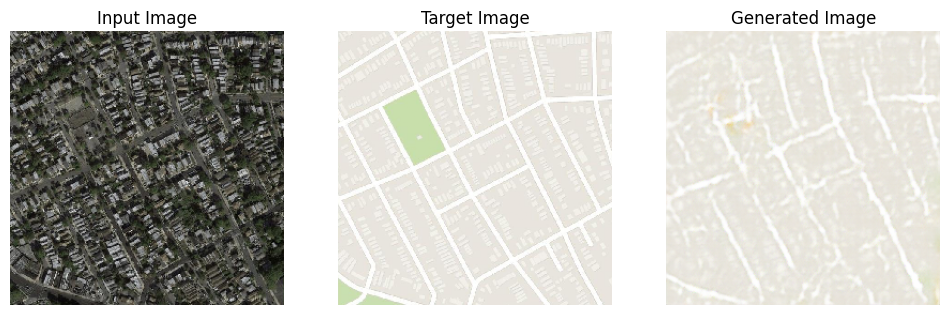

1/1 [==============================] - 0s 84ms/step


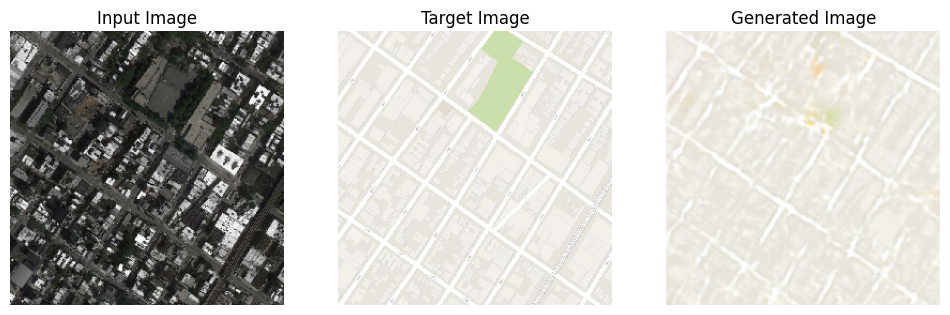

1/1 [==============================] - 0s 93ms/step


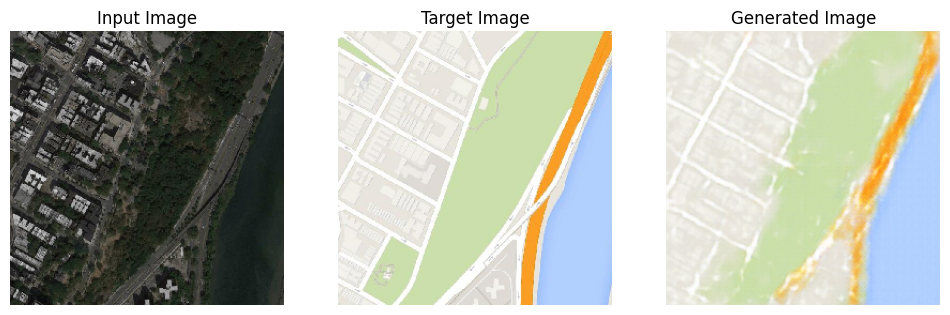

1/1 [==============================] - 0s 82ms/step


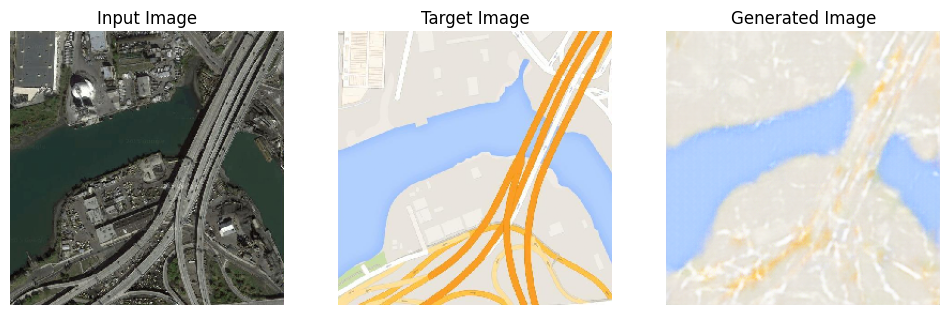

1/1 [==============================] - 0s 83ms/step


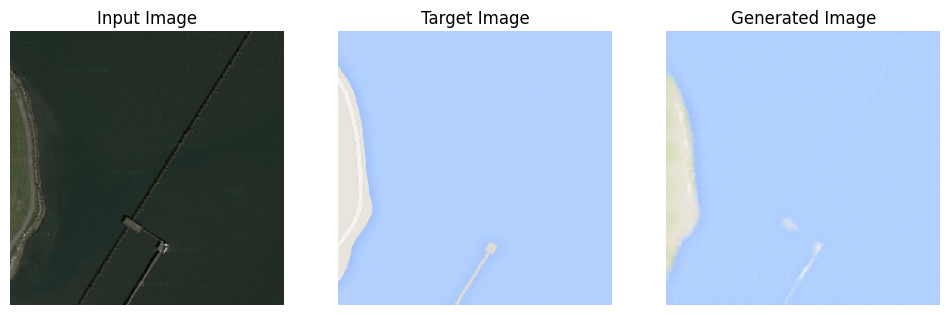

1/1 [==============================] - 0s 95ms/step


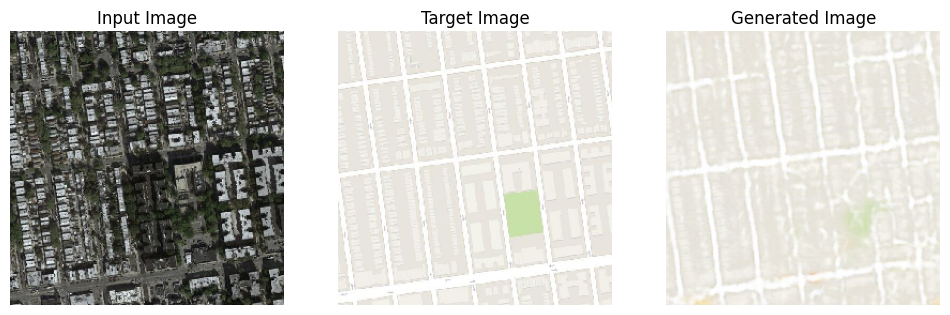

In [ ]:
def visualize_generated_image(generator, input_image, target_image):
    """
    Visualize an input image, its corresponding target image, and the image generated by the GAN.

    Args:
    - generator: The trained generator model.
    - input_image: The input image from the dataset.
    - target_image: The target image (ground truth) from the dataset.
    """
    # Generate an image using the generator
    generated_image = generator.predict(np.expand_dims(input_image, axis=0))[0]

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Plot the input image
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow((input_image + 1) / 2)
    plt.axis('off')

    # Plot the target image
    plt.subplot(1, 3, 2)
    plt.title('Target Image')
    plt.imshow((target_image + 1) / 2)
    plt.axis('off')

    # Plot the generated image
    plt.subplot(1, 3, 3)
    plt.title('Generated Image')
    plt.imshow((generated_image + 1) / 2)
    plt.axis('off')

    plt.show()

for i in [905, 906, 907, 908, 909, 910]:
    sample_index = i
    input_image = sat_imgs[sample_index]
    target_image = map_imgs[sample_index]

    visualize_generated_image(generator, input_image, target_image)